In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
import os, sys

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import hasasia.sensitivity as hassens
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [38]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [39]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise as SnN
import SNRcalc as SnC

LISA_Other_filedirectory = load_directory + 'LISA_Other/StrainFiles/'
LISA_Neil_filedirectory = load_directory + 'LISA_Neil/StrainFiles/'
LISA_ESA_filedirectory = load_directory + 'LISA_ESA/StrainFiles/'
ET_filedirectory = load_directory + 'EinsteinTelescope/StrainFiles/'
aLIGO_filedirectory = load_directory + 'aLIGO/StrainFiles/'
NANOGrav_filedirectory = load_directory + 'NANOGrav/StrainFiles/' 
EOBdiff_filedirectory = top_directory + '/LoadFiles/DiffStrain/EOBdiff/'

In [40]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

In [41]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

In [42]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 3

####################################################################
# Initialize different instruments

### aLIGO

In [43]:
Ground_T_obs = 4*u.yr

In [44]:
#aLIGO
aLIGO_filename = 'aLIGODesign.txt'
aLIGO_filelocation = aLIGO_filedirectory + aLIGO_filename

aLIGO = SnN.GroundBased('aLIGO',aLIGO_filelocation,Ground_T_obs)

### Einstein Telescope

In [45]:
#Einstein Telescope
ET_filename = 'ET_B_data.txt'
ET_filelocation = ET_filedirectory + ET_filename
ET_data = np.loadtxt(ET_filelocation)

ET = SnN.GroundBased('ET',ET_filelocation,Ground_T_obs)

### Plots of Ground Detectors

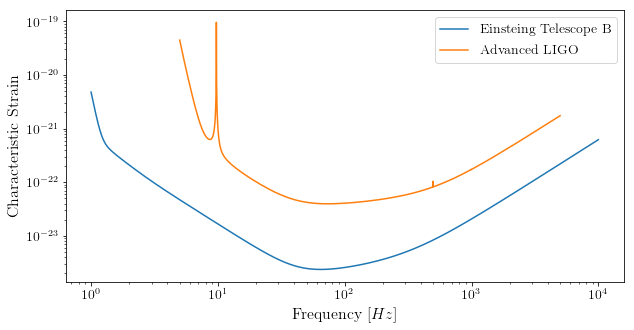

In [46]:
fig = plt.figure(figsize=(10,5))
plt.loglog(ET_f,np.sqrt(ET_f)*ET_S_n_f,label='Einsteing Telescope B')
plt.loglog(aLIGO_f,np.sqrt(aLIGO_f)*aLIGO_S_n_f,label='Advanced LIGO')
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend()

#########################
#Save Figure to File
figname = '/Ground_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

In [47]:
#########################
#Save Figure to File
figname = '/Ground_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')

### LISA Martin data

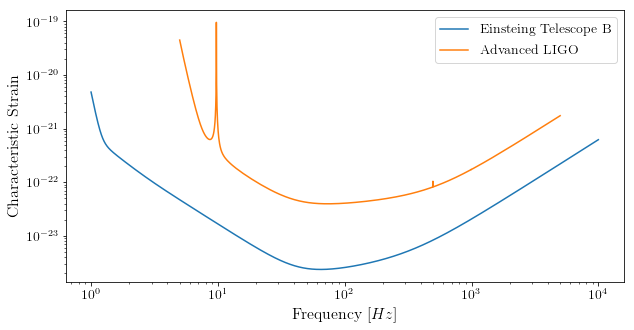

In [48]:
fig = plt.figure(figsize=(10,5))
plt.loglog(ET.fT,ET.h_n_f,label='Einsteing Telescope B')
plt.loglog(aLIGO.fT,aLIGO.h_n_f,label='Advanced LIGO')
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend()

#########################
#Save Figure to File
figname = '/Ground_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

### LISA Martin data

In [49]:
#Neil Cornish data
LISA_Neil_filename = 'LISA_sensitivity.txt'
LISA_Neil_filelocation = LISA_Neil_filedirectory + LISA_Neil_filename
LISA_Neil_data = np.loadtxt(LISA_Neil_filelocation)
LISA_Neil_f = LISA_Neil_data[:,0]*u.Hz
LISA_Neil_S_n_f = LISA_Neil_data[:,1]/u.Hz

### LISA Larson Sensitivity Curve

In [50]:
#Larson Sensitivity Curve
LISA_Larson_filename = 'scg_6981.dat'
LISA_Larson_filelocation = LISA_Other_filedirectory + LISA_Larson_filename
LISA_Larson_data = np.loadtxt(LISA_Larson_filelocation)
LISA_Larson_f = LISA_Larson_data[:,0]*u.Hz
LISA_Larson_S_n_f = LISA_Larson_data[:,1]/u.Hz #May be wrong units

### Numerical Relativity from EOB subtraction

#### Diff0002

In [51]:
diff0002_filename = 'diff0002.dat'
diff0002_filelocation = EOBdiff_filedirectory + diff0002_filename
diff0002_data = np.loadtxt(diff0002_filelocation)
diff0002_t = diff0002_data[:,0]*u.s
diff0002_hp = diff0002_data[:,1] #May be wrong units
diff0002_hc = diff0002_data[:,2] #May be wrong units

### LISA Neil Cornish data

In [52]:
#Neil Cornish data
LISA_Neil_filename = 'LISA_sensitivity.txt'
LISA_Neil_filelocation = LISA_Neil_filedirectory + LISA_Neil_filename

#Should be ENSD
LISA_Neil = SnN.SpaceBased('LISA_Neil',load_location=LISA_Neil_filelocation,I_type='E')

### LISA Larson Sensitivity Curve

In [53]:
diff0178_filename = 'diff0178.dat'
diff0178_filelocation = EOBdiff_filedirectory + diff0178_filename
diff0178_data = np.loadtxt(diff0178_filelocation)
diff0178_t = diff0178_data[:,0]*u.s
diff0178_hp = diff0178_data[:,1] #May be wrong units
diff0178_hc = diff0178_data[:,2] #May be wrong units

#### Diff0261

In [54]:
diff0261_filename = 'diff0261.dat'
diff0261_filelocation = EOBdiff_filedirectory + diff0261_filename
diff0261_data = np.loadtxt(diff0261_filelocation)
diff0261_t = diff0261_data[:,0]*u.s
diff0261_hp = diff0261_data[:,1] #May be wrong units
diff0261_hc = diff0261_data[:,2] #May be wrong units

#### Diff0303

In [55]:
diff0303_filename = 'diff0303.dat'
diff0303_filelocation = EOBdiff_filedirectory + diff0303_filename
diff0303_data = np.loadtxt(diff0303_filelocation)
diff0303_t = diff0303_data[:,0]*u.s
diff0303_hp = diff0303_data[:,1] #May be wrong units
diff0303_hc = diff0303_data[:,2] #May be wrong units

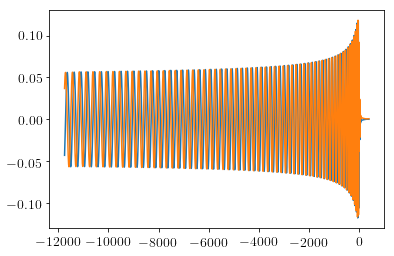

In [56]:
plt.figure()
plt.plot(diff0002_t,diff0002_hc)
plt.plot(diff0002_t,diff0002_hp)
plt.show()

In [57]:
hc_f = np.fft.fft(diff0002_hc)
hp_f = np.fft.fft(diff0002_hp)
h_f_no_win = np.sqrt((np.abs(hc_f))**2 + (np.abs(hp_f))**2)

31541
630


/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


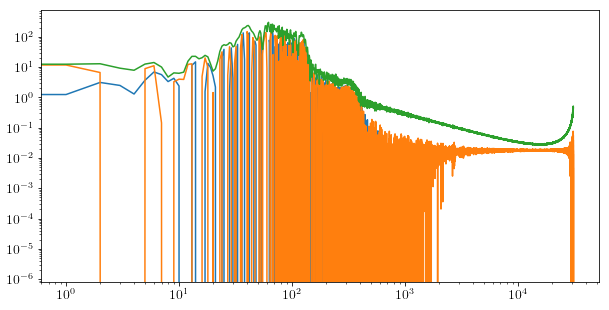

In [58]:
print(len(hc_f))
cut=int(len(hc_f)*0.02)
print(cut)
plt.figure(figsize=(10,5))
plt.plot(hc_f[:(len(hc_f)-cut)])
plt.plot(hp_f[:(len(hp_f)-cut)])
plt.plot(h_f_no_win[:(len(h_f_no_win)-cut)])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [59]:
diff0002_f,diff0002_h_f = SnN.Get_hf_from_hcross_hplus(diff0002_t,diff0002_hc,diff0002_hp,interp_res='coarse',windowing='left')

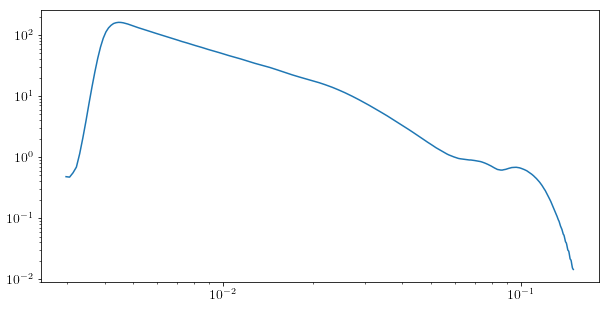

In [60]:
fig = plt.figure(figsize=(10,5))
plt.loglog(LISA_Martin.fT,LISA_Martin.h_n_f,label='LISA Martin file')
plt.loglog(LISA_Neil.fT,LISA_Neil.h_n_f,label='LISA Neil file')
plt.loglog(LISA_Larson.fT,LISA_Larson.h_n_f,label='LISA Larson file')
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend()

#########################
#Save Figure to File
figname = '/Ground_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

### NANOGrav continuous wave sensitivity

In [61]:
#NANOGrav continuous wave sensitivity
NANOGrav_background = 4e-16 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs = 15 #Observation years: 15,20,25

NANOGrav_filename = 'cw_simulation_Ared_' + str(NANOGrav_background) + '_dp_' + str(NANOGrav_dp) \
                    + '_fap_' + str(NANOGrav_fap) + '_T_' + str(NANOGrav_Tobs) + '.txt'
NANOGrav_filelocation = NANOGrav_filedirectory + NANOGrav_filename

NANOGrav_Mingarelli_no_GWB = SnN.PTA('NANOGrav_Mingarelli_no_GWB',load_location=NANOGrav_filelocation)

In [62]:
#NANOGrav continuous wave sensitivity
NANOGrav_background_2 = 0 # Unsubtracted GWB amplitude: 0,4e-16
NANOGrav_dp_2 = 0.95 #Detection Probablility: 0.95,0.5
NANOGrav_fap_2 = 0.0001 #False Alarm Probability: 0.05,0.003,0.001,0.0001
NANOGrav_Tobs_2 = 15 #Observation years: 15,20,25

NANOGrav_filename_2 = 'cw_simulation_Ared_' + str(NANOGrav_background_2) + '_dp_' + str(NANOGrav_dp_2) \
                    + '_fap_' + str(NANOGrav_fap_2) + '_T_' + str(NANOGrav_Tobs_2) + '.txt'
NANOGrav_filelocation_2 = NANOGrav_filedirectory + NANOGrav_filename_2

NANOGrav_Mingarelli_GWB = SnN.PTA('NANOGrav_Mingarelli_GWB',load_location=NANOGrav_filelocation_2)

### SKA  parameters and methods from arXiv:0804.4476 section 7.1

In [63]:
###############################################
#SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
sigma_SKA = 10*u.ns.to('s')*u.s #sigma_rms timing residuals in nanoseconds to seconds
T_SKA = 15*u.yr #Observing time in years
N_p_SKA = 20 #Number of pulsars
cadence_SKA = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in [number/yr]

In [22]:
SKA_Hazboun = SnN.PTA('SKA_Hazboun',T_SKA,N_p_SKA,sigma_SKA,cadence_SKA)

In [64]:
SKA_Hazboun_wRN = SnN.PTA('SKA_Hazboun_wRN',T_SKA,N_p_SKA,sigma_SKA,cadence_SKA,A_rn=[1e-16,1e-12],alpha_rn=[-3/4,1])

In [65]:
SKA_Hazboun_wGWB = SnN.PTA('SKA_Hazboun_wGWB',T_SKA,N_p_SKA,sigma_SKA,cadence_SKA,A_GWB=4e-16)

#### Using Jeff's Methods/code https://arxiv.org/abs/1907.04341

### NANOGrav 11.5yr parameters https://arxiv.org/abs/1801.01837

In [66]:
###############################################
#NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
sigma_nano = 100*u.ns.to('s')*u.s #rms timing residuals in nanoseconds to seconds
T_nano = 15*u.yr #Observing time in years
N_p_nano = 18 #Number of pulsars
cadence_nano = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in number/year

In [26]:
NANOGrav_Hazboun = SnN.PTA('NANOGrav_Hazboun',T_nano,N_p_nano,sigma_nano,cadence_nano)

In [27]:
NANOGrav_Hazboun_wRN = SnN.PTA('NANOGrav_Hazboun_wRN',T_nano,N_p_nano,sigma_nano,cadence_nano,A_rn=[1e-16,1e-12],alpha_rn=[-3/4,1])

In [67]:
NANOGrav_Hazboun_wGWB = SnN.PTA('NANOGrav_Hazboun_wGWB',T_nano,N_p_nano,sigma_nano,cadence_nano,A_GWB=4e-16)

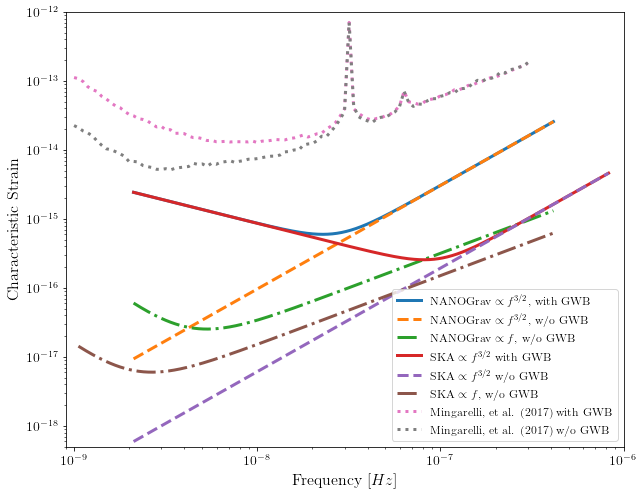

In [70]:
fig = plt.figure(figsize=(10,8))
plt.loglog(NANOGrav_f_1,np.sqrt(NANOGrav_f_1)*NANOGrav_S_n_f_1, linewidth = linesize,\
           label = r'NANOGrav $\propto f^{3/2}$, with GWB')
plt.loglog(NANOGrav_f_3,np.sqrt(NANOGrav_f_3)*NANOGrav_S_n_f_3,linestyle = '--', linewidth = linesize,\
           label = r'NANOGrav $\propto f^{3/2}$, w/o GWB')
plt.loglog(NANOGrav_f_2,NANOGrav_strain,linestyle = '-.', linewidth = linesize,\
           label = r'NANOGrav $\propto f$, w/o GWB')
plt.loglog(SKA_f_3,np.sqrt(SKA_f_3)*SKA_S_n_f_3, linewidth = linesize,\
           label = r'SKA $\propto f^{3/2}$ with GWB')
plt.loglog(SKA_f_4,np.sqrt(SKA_f_4)*SKA_S_n_f_4,linestyle = '--', linewidth = linesize,\
           label = r'SKA $\propto f^{3/2}$ w/o GWB')
plt.loglog(SKA_f_2,SKA_strain,linestyle = '-.', linewidth = linesize,\
           label = r'SKA $\propto f$, w/o GWB')
plt.loglog(NANOGrav_file_f,NANOGrav_file_h_f,linestyle = ':', linewidth = linesize,\
           label = r'Mingarelli, et al. (2017) with GWB')
plt.loglog(NANOGrav_Mingarelli_no_GWB.fT,NANOGrav_Mingarelli_no_GWB.h_n_f,linestyle = ':', linewidth = linesize,\
           label = r'Mingarelli, et al. (2017) w/o GWB')

plt.tick_params(axis = 'both',which = 'major', labelsize = axissize)
plt.ylim([5e-19,1e-11])
plt.xlim([3e-10,1e-6])
#plt.title('NANOGrav (15yr)',fontsize=labelsize)
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend(loc='lower right', fontsize = 12)

#########################
#Save Figure to File
figname = '/PTA_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

####################################################################
# Calculate LISA amplitude spectral densities for various models

In [22]:
#LISA Calculation without pathfinder correction (2016 model)
S_sci = 8.9e-12*u.m
S_loc = 1.7e-12*u.m
S_other = 2e-12*u.m

S_acc_low_knee = 30.*u.uHz.to('Hz')*u.Hz
S_acc_high_knee = 0.1*u.mHz.to('Hz')*u.Hz
S_acc_low = 1.8e-14*u.m/u.s/u.s
S_acc_high = 3e-15*u.m/u.s/u.s

#Make a dictionary of dictionaries to put all instrument values, minima, and maxima in a nice, concise form
Martin_LISA_inst_var_dict = {'LISA_Martin': {'L':{'val':L},
                 'Tobs':{'val':LISA_T_obs},
                 'S_sci':{'val':S_sci},
                 'S_loc':{'val':S_loc},
                 'S_other':{'val':S_other},
                 'S_acc_low_knee':{'val':S_acc_low_knee},
                 'S_acc_high_knee':{'val':S_acc_high_knee},
                 'S_acc_low':{'val':S_acc_low},
                 'S_acc_high':{'val':S_acc_high}}}

Martin_f,Martin_S_n_f_sqrt = SnN.MartinSensitivity(Martin_LISA_inst_var_dict)

### LISA Calculation from https://arxiv.org/pdf/1702.00786.pdf (Amaro-Seaone 2017)

In [27]:
#LISA Calculation WITH (Sean's) pathfinder correction
Ssci = 8.9e-12**2*u.m*u.m
Sloc = 1.7e-12**2*u.m*u.m
Sother = 2e-12**2*u.m*u.m
Martin_P_ims = Ssci+2*Sloc+Sother
pathfinder_f = fT
pathfinder_S_acc = ((60e-15*u.m/u.s/u.s)**2*(20e-6*u.Hz/pathfinder_f)**10 + (1.74e-15*u.m/u.s/u.s)**2)/(2*np.pi*pathfinder_f)**4 #Update Pathfinder Acceleration Noise
pathfinder_S_n_f_sqrt = SnN.Get_ASD_from_PSD_LISA(pathfinder_f,LISA_Transfer_Function,pathfinder_S_acc,Martin_P_ims,L) #Updated LISA noise curve with Pathfinder Acc noise

### Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf

In [24]:
#Neil Calculation from https://arxiv.org/pdf/1803.01944.pdf
f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 1.5e-11*u.m
Background = False
    
Neil_LISA = SnN.SpaceBased('Neil_LISA',\
                           LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                           Background=Background)

### Plots of Modelled/Current LISA Proposals

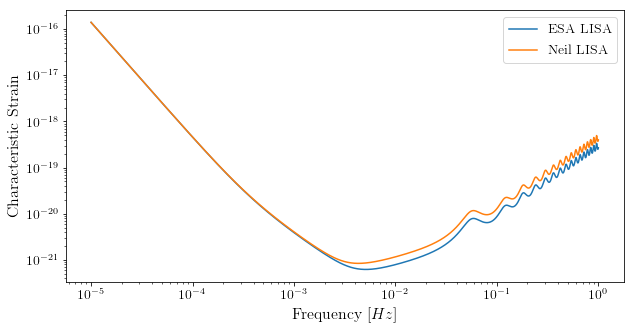

In [25]:
fig = plt.figure(figsize=(10,5))
plt.loglog(ESA_LISA.fT,ESA_LISA.h_n_f,label='ESA LISA')
plt.loglog(Neil_LISA.fT,Neil_LISA.h_n_f,label='Neil LISA')
#plt.loglog(LISA_Martin.fT,LISA_Martin.h_n_f,label='LISA Martin file')
#plt.loglog(LISA_Neil.fT,LISA_Neil.h_n_f,label='LISA Neil file')
#plt.loglog(LISA_Larson.fT,LISA_Larson.h_n_f,label='LISA Larson file')
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend()
#########################
#Save Figure to File
figname = '/LISA_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

### Plots of Space-Based Detectors

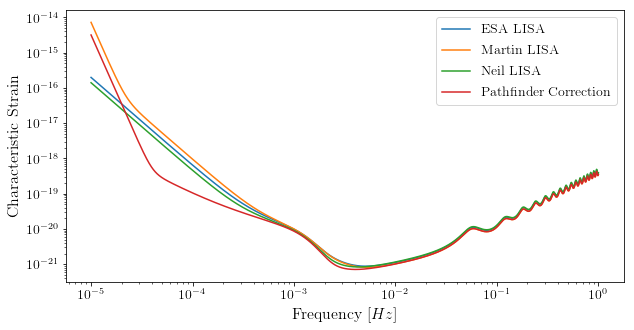

In [71]:
fig = plt.figure(figsize=(10,5))
plt.loglog(ESA_f,np.sqrt(ESA_f)*ESA_S_n_f_sqrt,label='ESA LISA')
plt.loglog(Martin_f,np.sqrt(Martin_f)*Martin_S_n_f_sqrt,label='Martin LISA')
plt.loglog(Neil_f,np.sqrt(Neil_f)*Neil_S_n_f_sqrt,label='Neil LISA')
plt.loglog(pathfinder_f,np.sqrt(pathfinder_f)*pathfinder_S_n_f_sqrt,label='Pathfinder Correction')
plt.xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
plt.ylabel('Characteristic Strain',fontsize = labelsize)
plt.legend()
#########################
#Save Figure to File
figname = '/LISA_Char_Strain.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()

#######################################################################
# BBH strain calculation

In [48]:
#Vars = [M,q,chi1,chi2,z]
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]
inc = 0.0 #Assume optimally oriented

Vars1 = [M[0],q[0],x1[0],x2[0],z[0]]
Vars2 = [M[1],q[1],x1[1],x2[1],z[1]]
Vars3 = [M[2],q[2],x1[2],x2[2],z[2]]
Vars4 = [M[1],q[0],x1[1],x2[1],z[1]]

In [39]:
source_1 = SnN.BlackHoleBinary(M[0],q[0],x1[0],x2[0],z[0],inc,instrument=ESA_LISA)

/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [37]:
#From PhenomD
[phenomD_f_1,phenomD_h_1] = SnN.Get_Waveform(Vars1,f_low=1e-4)
[phenomD_f_2,phenomD_h_2] = SnN.Get_Waveform(Vars2,f_low=1e-4)
[phenomD_f_3,phenomD_h_3] = SnN.Get_Waveform(Vars3)

In [38]:
#Get characteristic strain for PhenomD waveform
[phenomD_f_1,phenomD_h_char_1] = SnN.Get_CharStrain(Vars1,phenomD_f_1,phenomD_h_1)
[phenomD_f_2,phenomD_h_char_2] = SnN.Get_CharStrain(Vars2,phenomD_f_2,phenomD_h_2)
[phenomD_f_3,phenomD_h_char_3] = SnN.Get_CharStrain(Vars3,phenomD_f_3,phenomD_h_3)

In [39]:
source_2 = SnN.BlackHoleBinary(M[1],q[1],x1[1],x2[1],z[1],inc,instrument=aLIGO)

/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [40]:
source_3 = SnN.BlackHoleBinary(M[2],q[2],x1[2],x2[2],z[2],inc,instrument=SKA_Hazboun)

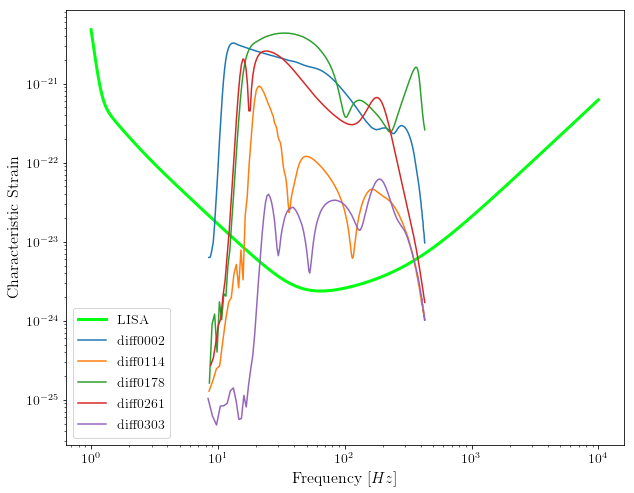

In [41]:
source_4 = SnN.BlackHoleBinary(M[1],q[0],x1[1],x2[1],z[1],inc,instrument=ET)

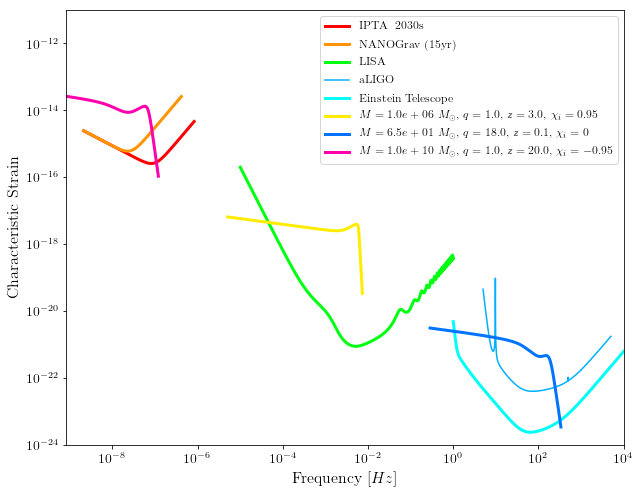

In [47]:
fig,ax = plt.subplots(figsize = figsize)
#plt.loglog(NANOGrav_f,NANOGrav_h_f)
ax.loglog(SKA_Hazboun.fT,SKA_Hazboun.h_n_f, linewidth = linesize,color = cm.hsv(colornorm(0.0)),label = 'IPTA ~2030s')
ax.loglog(NANOGrav_Hazboun.fT,NANOGrav_Hazboun.h_n_f, linewidth = linesize,color = cm.hsv(colornorm(0.5)),\
          label = 'NANOGrav (15yr)')
ax.loglog(ESA_LISA.fT,ESA_LISA.h_n_f, linewidth = linesize,color = cm.hsv(colornorm(1.75)),label = 'LISA')
ax.loglog(aLIGO.fT,aLIGO.h_n_f,color = cm.hsv(colornorm(2.8)),label = 'aLIGO')
ax.loglog(ET.fT,ET.h_n_f, linewidth = linesize,color = cm.hsv(colornorm(2.5)),label = 'Einstein Telescope')

ax.loglog(source_1.f,SnN.Get_CharStrain(source_1), linewidth = linesize,color = cm.hsv(colornorm(0.8)),\
          label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[0],q[0],z[0],x1[0]))

ax.loglog(source_2.f,SnN.Get_CharStrain(source_2), linewidth = linesize,color = cm.hsv(colornorm(3.0)),\
          label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.0f$' %(M[1],q[1],z[1],x1[1]))

ax.loglog(source_3.f,SnN.Get_CharStrain(source_3), linewidth = linesize,color = cm.hsv(colornorm(4.5)),\
          label = r'$M = %.1e$ $M_{\odot}$, $q = %.1f$, $z = %.1f$, $\chi_{i} = %.2f$' %(M[2],q[2],z[2],x1[2]))


ax.set_xlim([1e-10, 1e4])
ax.set_ylim([1e-24, 1e-11])
ax.tick_params(axis = 'both',which = 'major', labelsize = axissize)

ax.set_xlabel(r'Frequency $[Hz]$',fontsize = labelsize)
ax.set_ylabel('Characteristic Strain',fontsize = labelsize)
ax.legend(loc='upper right', fontsize = legendsize)

#########################
#Save Figure to File
figname = '/Char_Strain_v2.pdf'
figloc = fig_save_location+figname
isitsavetime = False
if isitsavetime:
    fig.savefig(figloc, bbox_inches='tight')
    
plt.show()